In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.style.use('seaborn-bright')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.graphics.tsaplots import *
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\moham\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Load Dataset
data = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBElec.csv')
HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
HUElec = HUElec.set_index('Datetime')
HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
HUElec.head()

,value
Datetime,
2008-03-03 00:00:00,0.0
2008-03-03 00:30:00,0.0
2008-03-03 01:00:00,0.0
2008-03-03 01:30:00,0.0
2008-03-03 02:00:00,0.0


In [3]:
data = HUElec.resample(rule='H').mean().copy()

data.fillna(method='ffill',  inplace=True)

data.head()

,value
Datetime,
2008-03-03 00:00:00,0.0
2008-03-03 01:00:00,0.0
2008-03-03 02:00:00,0.0
2008-03-03 03:00:00,0.0
2008-03-03 04:00:00,0.0


In [4]:
def create_features(df, target_variable):
    """
    Creates time series features from datetime index
    
    Args:
        df (float64): Values to be added to the model incl. corresponding datetime
                      , numpy array of floats
        target_variable (string): Name of the target variable within df   
    
    Returns:
        X (int): Extracted values from datetime index, dataframe
        y (int): Values of target variable, numpy array of integers
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear']]
    if target_variable:
        y = df[target_variable]
        return X, y
    return X

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)}',end='\n\n')

In [9]:
from pmdarima.model_selection import train_test_split as time_train_test_split

X = data['value']

# Test Size = 20%
train_data, test_data = time_train_test_split(X, test_size=int(len(data)*0.1))

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

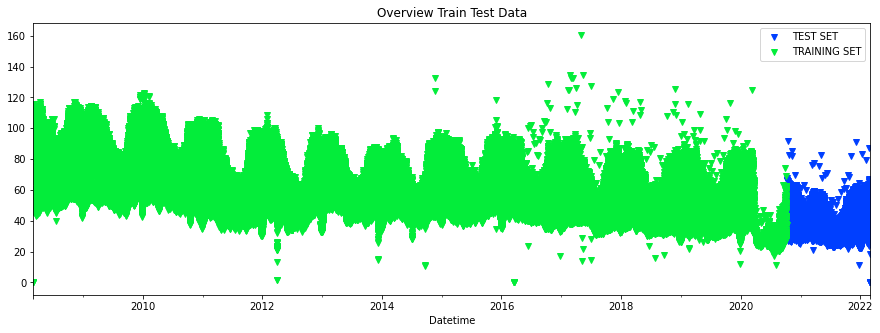

In [10]:
Overview_Train_Test_Data = test_data \
    .rename(columns={'value': 'TEST SET'}) \
    .join(train_data.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Overview Train Test Data', style='v')

In [11]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

trainX, trainY = create_features(train_data_copy, target_variable='value')
testX, testY = create_features(test_data_copy, target_variable='value')

<ipython-input-4-2394359a5459>:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-4-2394359a5459>:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [12]:
xgb = XGBRegressor(objective='reg:squarederror',
    n_estimators=5000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
)

xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=50,
        verbose=False)

C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

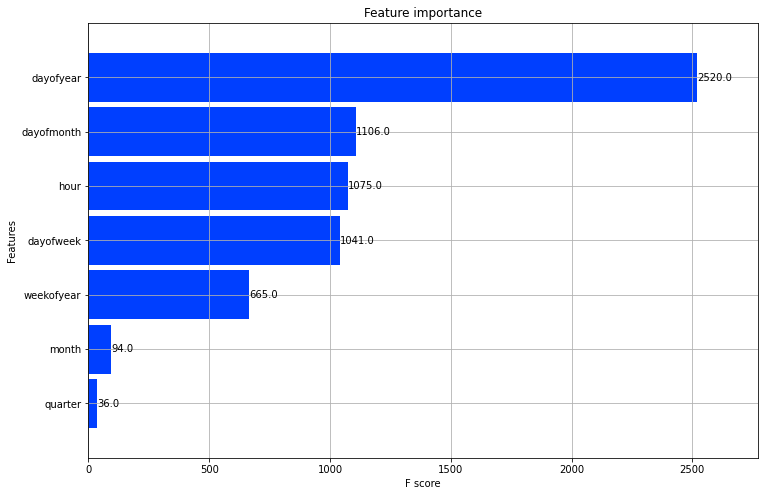

In [13]:
from xgboost import plot_importance

feature_importance = plot_importance(xgb, height=0.9)
feature_importance

In [14]:
predicted_results = xgb.predict(testX)
predicted_results

array([30.388258, 29.598738, 29.113499, ..., 35.771736, 33.727734,
       33.727734], dtype=float32)

In [15]:
timeseries_evaluation_metrics_func(testY, predicted_results)

MSE is : 20.711534586526334
MAE is : 3.005630107567448
RMSE is : 4.5509927034138755
MAPE is : inf
R2 is : 0.7897278958849037



<ipython-input-5-16144db3b5a6>:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


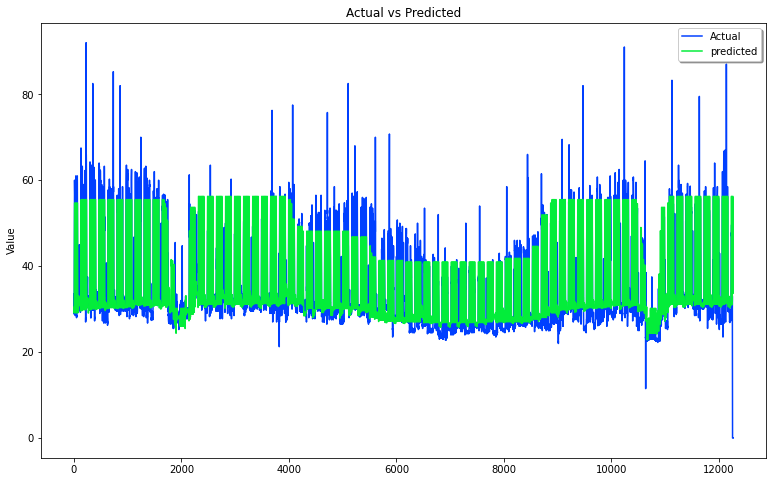

In [16]:
plt.figure(figsize=(13,8))
plt.plot(list(testY))
plt.plot(list(predicted_results))
plt.title("Actual vs Predicted")
plt.ylabel("Value")
plt.legend(('Actual','predicted'), shadow=True)
plt.show()

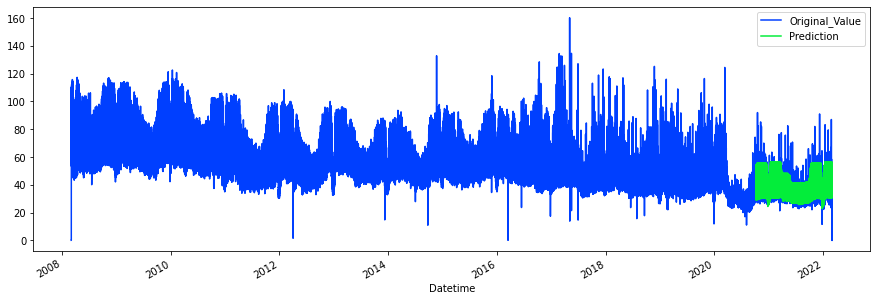

In [17]:
test_data['Prediction'] = predicted_results
pjme_all = pd.concat([test_data, train_data], sort=False)
pjme_all = pjme_all.rename(columns={'value':'Original_Value'})

Overview_Complete_Data_And_Prediction = pjme_all[['Original_Value','Prediction']].plot(figsize=(15, 5))